# 1 Author

**Student Name**:  Yuchen Fan

**Student ID**:  210977729


# 2 Problem formulation

**1. Classification: Detecting whether the people in the picture is smiling or not**

It is useful to correctly classify the facial expression of a person, especially for psychology, human behavior analysis and so on. Besides, a SOTA model can be implemented as an automatic annotater, saving time and cost. 

**2. Regression: Find the 3-D position of the head pose of the people in the picture**

By detecting fine-grained position of head pose, we can further analyze the mapping from 3-D position to some certain facial expressions. Besides, a SOTA model can be implemented as an automatic annotater, saving time and cost. 



# 3 Machine Learning pipeline

The ML pipeline is as follows:

Preprocess dataset -> Data Augumentation -> Fit a model -> Evaluate the model.

For two problems mentioned in Cell 2, they are different tasks. Therefore, I suppose that two models should be trained seperately to make predictions.

**For Classification:**

The input is a matrix representing the specific encoding method of a picture, for instance, RGB or grayscale. The output is a 0-1 label. 

The **Data Augumentation** process process the dataset by rotating, removing some pixels, Flipping and so on.

**For Regression:**

The input is a matrix representing the specific encoding method of a picture, for instance, RGB or grayscale. The output is three float numbers.

The **Data Augumentation** process process the dataset by rotating, removing some pixels, Flipping and so on.

# 4 Transformation stage

For a picture, what matters is the order of the pixeds and the value of each pixel. In my procession, I flip and rotate some of the pictures, normalize the values of pixels to 0 - 1 and randomly drop some pixels.

By using transformation, the effectiveness and robustness of the model will be improved a lot, overfitting will be avoided.

The implementation are as follows

In [1]:
from torchvision import transforms

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 5 Modelling

In this section, I will try several models:

**SVM:**

To employ what I have learnt in the class, I use sklearn library to implement SVM. It is based on feature enginnering and statistical learning, somewhat different from deep neural network.

**CNN:**

CNN is universally acknowledged to be efficient for image. And it is thought to be a great fundation of DL. I use a three layer simple CNN for classification.

**ResNet:**

ResNet is a great breakthrough in DL, indicating a new era. Its structure avoids gradient disapperances, acclerating the training process. To dive into the effects of the number of layers do to the performance, I use two variants, e.g. ResNet18 and ResNet50


In [8]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 56 * 56, 128) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [3]:
from torchvision import models
from sklearn.svm import SVC

# Initialize the model
svm = SVC(kernel='linear', gamma='auto')
resnet = models.resnet50(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
cnn = CNN(num_classes=2)
cnn_detection = CNN(num_classes=3)

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weight

# 6 Methodology

**Train:**

For deep learning model, I firstly set some hyperparameters the number of epochs as 100, the learning rate as 0.001, the batch size as 32. Then, I implement the loss function as CrossEntropy, the optimizer as Ada and the learning rate decay parameter. Afterwards, I begin the training loop. In each iteration, the input from the train dataset is in the format as *(batch_size, height, width)*, and then I do back propagation based on the model outputs and the labels. Moreover, I implement an early-stop strategy. If the accuracy has not been improved for 10 epoch, it should be considered overfitting.

For machine learning model, I just fit *X* to *y*.

**Test:**

I use the validation dataset to test. Beforeheads, I set the model mode as eval and repeat the process in the training process without upgrading the parameters. To be mentioned, I use accuracy as the evaluation metric for classification and MSE for detection.

**Evaluation Metric:**

Specifically, Accuracy is regarded as the golden standard for classification. MSE is considered gold for regression.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import numpy as np
import copy
from tqdm import tqdm

# Train the model
def train(model_name, model, train_loader, val_loader, test_loader, task):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'------------------------------------------------{model_name}------------------------------------------------')
    
    # Initialize the model
    if task == 'classification':
        if model_name == 'resnet':
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 2)
        elif model_name == 'resnet18':
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 2)
    if task == 'Detection':
        if model_name == 'resnet':
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 3)
        elif model_name == 'resnet18':
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 3)
    model = model.to(device)

    # Define the loss function and optimizer
    if task == 'classification':
        criterion = nn.CrossEntropyLoss()
    elif task == 'Detection':
        mse_criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 

    train_losses, val_losses = [], []
    train_mse_losses, val_mse_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_mse = float('inf') 
    early_stopping_counter = 0

    num_epochs = 100 

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        train_loss = 0.0
        train_mse_loss = 0.0
        train_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            if task == 'Detection':
                labels = labels.float()
                mse_loss = mse_criterion(outputs, labels)
                train_mse_loss += mse_loss.item() * inputs.size(0)

                loss = mse_loss
            elif task == 'classification':
                labels = labels.long()
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                train_corrects += torch.sum(preds == labels.data)

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)



        scheduler.step()
        epoch_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        if task == 'Detection':
            epoch_train_mse_loss = train_mse_loss / len(train_loader.dataset)
            train_mse_losses.append(epoch_train_mse_loss)
        elif task == 'classification':
            epoch_train_acc = train_corrects.double() / len(train_loader.dataset)
            train_accuracies.append(epoch_train_acc.item())
            
        if task == 'Detection':
            print(f'Train mse Loss: {epoch_train_mse_loss:.4f}')
        elif task == 'classification':
            print(f'Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f}')
            
        model.eval()
        val_corrects = 0
        val_loss = 0
        val_mse_loss = 0
        
        # Validation phase
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                if task == 'Detection':
                    labels = torch.tensor(labels, dtype=torch.float)
                elif task == 'classification':
                    labels = torch.tensor(labels, dtype=torch.long)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if task == 'Detection':
                    labels = labels.float()
                    mse_loss = mse_criterion(outputs, labels)
                    val_mse_loss += mse_loss.item() * inputs.size(0)

                    loss = mse_loss
                elif task == 'classification':
                    labels = labels.long()
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
                val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        if task == 'Detection':
            epoch_val_mse_loss = val_mse_loss / len(val_loader.dataset)
            val_mse_losses.append(epoch_val_mse_loss)
        elif task == 'classification':
            epoch_val_acc = val_corrects / len(val_loader.dataset)
            val_accuracies.append(epoch_val_acc.item())
            
        if task == 'Detection':
            print(f'Val mse Loss: {epoch_val_mse_loss:.4f}')

        if task == 'Detection' and epoch_val_mse_loss < best_mse:
            best_mse = epoch_val_mse_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        elif task == 'classification' and epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if task == 'classification':
            print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        if early_stopping_counter > 10:
            print('Early stopping')
            break

    torch.save(best_model_wts, f'{model_name}-{task}.pth')

    model.load_state_dict(best_model_wts)

    # Test phase
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_mse_loss = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if task == 'Detection':
                labels = labels.float()
                mse_loss = mse_criterion(outputs, labels)
                test_mse_loss += mse_loss.item() * inputs.size(0)
            elif task == 'classification':
                labels = labels.long()
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

    # Calculate and print test metrics
    if task == 'Detection':
        avg_test_mse_loss = test_mse_loss / len(test_loader.dataset)
        print(f'Test MSE Loss: {avg_test_mse_loss:.4f}')
    elif task == 'classification':
        test_accuracy = test_corrects.double() / len(test_loader.dataset)
        print(f'Test Accuracy: {test_accuracy:.4f}')

    # Return train, validation, and test metrics
    if task == 'Detection':
        return train_mse_losses, val_mse_losses
    elif task == 'classification':
        return train_losses, train_accuracies, val_losses, val_accuracies

# 7 Dataset

At first, I read in the images and labels, making them a dataset.

Then as mentioned above, I did some preprocess, for instance, normalization, dropping pixels, flipping, ratation and so on.

Besides, I split the train-validation-test dataset in the ration of 7:1.5:1.5.

Afterwards, I built a class named MyDataset to make pipeline work more fluently.

In [5]:
'''
load dataset
'''

import cv2
import os


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
root = 'Your path here'
predictors = []

classification_labels = []
detection_labels = []
with open('Your path here') as f:
    for line in f.readlines():
        classification_labels.append(int(line[0]))
        line = line[2:].split()
        detection_labels.append((float(line[0]), float(line[1]), float(line[2])))
        
for i in range(len(detection_labels)):
    detection_label = detection_labels[i]
    classification_label = classification_labels[i]
    filename = f'{root}\\file{str(i+1).zfill(4)}.jpg'
    img = cv2.imread(filename)
    img = cv2.resize(img, (256, 256))
    predictors.append(img)

classification_dataset = []
for i in range(len(classification_labels)):
    classification_dataset.append((predictors[i], classification_labels[i]))
    
detection_dataset = []
for i in range(len(detection_labels)):
    detection_dataset.append((predictors[i], detection_labels[i]))
    

In [6]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, predictors, labels, transform=None):
        assert len(predictors) == len(labels), "Length of predictors and labels should be equal"
        self.predictors = predictors
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.predictors[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

# Split ratios
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Creating datasets
classification_dataset = MyDataset(predictors, classification_labels, transform)
detection_dataset = MyDataset(predictors, detection_labels, transform)

# Splitting datasets
train_size = int(ratio_train * len(classification_dataset))
val_size = int(ratio_val * len(classification_dataset))
test_size = len(classification_dataset) - train_size - val_size

train_classification_dataset, val_classification_dataset, test_classification_dataset = torch.utils.data.random_split(classification_dataset, [train_size, val_size, test_size])
train_detection_dataset, val_detection_dataset, test_detection_dataset = torch.utils.data.random_split(detection_dataset, [train_size, val_size, test_size])

# Data loaders
train_classification_loader = DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
val_classification_loader = DataLoader(val_classification_dataset, batch_size=32, shuffle=False)
test_classification_loader = DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

train_detection_loader = DataLoader(train_detection_dataset, batch_size=32, shuffle=True)
val_detection_loader = DataLoader(val_detection_dataset, batch_size=32, shuffle=False)
test_detection_loader = DataLoader(test_detection_dataset, batch_size=32, shuffle=False)


Considering that using SVM needs a quite great amount of memory to store an array, perhaps causing out-of-memory problem. Below is used to generate **equally batch data** for SVM

In [7]:
def data_generator(dataset, batch_size=32):
    n = len(dataset)
    while True:
        for i in range(0, n, batch_size):
            X, y = [], []
            for j in range(i, min(i + batch_size, n)):
                img, label = dataset[j]
                img_flat = np.array(img).flatten()  # 将图像展平
                X.append(img_flat)
                y.append(label)
            yield np.array(X), np.array(y)

# 8 Results
### Classification
The results of ResNet are as follows:


In [38]:
train_losses_resnet, train_accuracies_resnet, val_losses_resnet, val_accuracies_resnet = train('resnet', resnet, train_classification_loader, val_classification_loader, test_classification_loader, 'classification')

------------------------------------------------resnet------------------------------------------------
Epoch 1/100
----------


Training: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]


Train Loss: 0.5844 | Train Accuracy: 0.7207


Validation:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\yuche\AppData\Local\Temp\ipykernel_4396\1503659309.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
Validation: 100%|██████████| 19/19 [00:01<00:00,  9.96it/s]


Epoch 1/100: Train Loss: 0.5844 Acc: 0.7207 Val Loss: 0.6909 Acc: 0.7567
Epoch 2/100
----------


Training: 100%|██████████| 88/88 [00:34<00:00,  2.53it/s]


Train Loss: 0.3487 | Train Accuracy: 0.8532


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.76it/s]


Epoch 2/100: Train Loss: 0.3487 Acc: 0.8532 Val Loss: 0.3519 Acc: 0.8400
Epoch 3/100
----------


Training: 100%|██████████| 88/88 [00:36<00:00,  2.40it/s]


Train Loss: 0.2837 | Train Accuracy: 0.8846


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


Epoch 3/100: Train Loss: 0.2837 Acc: 0.8846 Val Loss: 0.2501 Acc: 0.8950
Epoch 4/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Train Loss: 0.2892 | Train Accuracy: 0.8879


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.98it/s]


Epoch 4/100: Train Loss: 0.2892 Acc: 0.8879 Val Loss: 0.2748 Acc: 0.8917
Epoch 5/100
----------


Training: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Train Loss: 0.2452 | Train Accuracy: 0.9021


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.59it/s]


Epoch 5/100: Train Loss: 0.2452 Acc: 0.9021 Val Loss: 0.2821 Acc: 0.8817
Epoch 6/100
----------


Training: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Train Loss: 0.2100 | Train Accuracy: 0.9200


Validation: 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


Epoch 6/100: Train Loss: 0.2100 Acc: 0.9200 Val Loss: 0.3122 Acc: 0.8783
Epoch 7/100
----------


Training: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Train Loss: 0.2041 | Train Accuracy: 0.9179


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.87it/s]


Epoch 7/100: Train Loss: 0.2041 Acc: 0.9179 Val Loss: 0.4059 Acc: 0.8683
Epoch 8/100
----------


Training: 100%|██████████| 88/88 [00:30<00:00,  2.85it/s]


Train Loss: 0.1974 | Train Accuracy: 0.9229


Validation: 100%|██████████| 19/19 [00:02<00:00,  8.82it/s]


Epoch 8/100: Train Loss: 0.1974 Acc: 0.9229 Val Loss: 0.5247 Acc: 0.8117
Epoch 9/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Train Loss: 0.1844 | Train Accuracy: 0.9286


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.79it/s]


Epoch 9/100: Train Loss: 0.1844 Acc: 0.9286 Val Loss: 0.3672 Acc: 0.8700
Epoch 10/100
----------


Training: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Train Loss: 0.1872 | Train Accuracy: 0.9250


Validation: 100%|██████████| 19/19 [00:02<00:00,  9.13it/s]


Epoch 10/100: Train Loss: 0.1872 Acc: 0.9250 Val Loss: 0.3466 Acc: 0.8550
Epoch 11/100
----------


Training: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Train Loss: 0.1635 | Train Accuracy: 0.9393


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.98it/s]


Epoch 11/100: Train Loss: 0.1635 Acc: 0.9393 Val Loss: 0.2087 Acc: 0.9233
Epoch 12/100
----------


Training: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s]


Train Loss: 0.1279 | Train Accuracy: 0.9554


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.51it/s]


Epoch 12/100: Train Loss: 0.1279 Acc: 0.9554 Val Loss: 0.1900 Acc: 0.9233
Epoch 13/100
----------


Training: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s]


Train Loss: 0.1128 | Train Accuracy: 0.9618


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.68it/s]


Epoch 13/100: Train Loss: 0.1128 Acc: 0.9618 Val Loss: 0.1832 Acc: 0.9400
Epoch 14/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]


Train Loss: 0.0978 | Train Accuracy: 0.9654


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


Epoch 14/100: Train Loss: 0.0978 Acc: 0.9654 Val Loss: 0.2063 Acc: 0.9267
Epoch 15/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


Train Loss: 0.0894 | Train Accuracy: 0.9707


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.81it/s]


Epoch 15/100: Train Loss: 0.0894 Acc: 0.9707 Val Loss: 0.2074 Acc: 0.9283
Epoch 16/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]


Train Loss: 0.0841 | Train Accuracy: 0.9696


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.05it/s]


Epoch 16/100: Train Loss: 0.0841 Acc: 0.9696 Val Loss: 0.2085 Acc: 0.9383
Epoch 17/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]


Train Loss: 0.0804 | Train Accuracy: 0.9721


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.79it/s]


Epoch 17/100: Train Loss: 0.0804 Acc: 0.9721 Val Loss: 0.1985 Acc: 0.9333
Epoch 18/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Train Loss: 0.0763 | Train Accuracy: 0.9743


Validation: 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


Epoch 18/100: Train Loss: 0.0763 Acc: 0.9743 Val Loss: 0.2394 Acc: 0.9333
Epoch 19/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Train Loss: 0.0737 | Train Accuracy: 0.9746


Validation: 100%|██████████| 19/19 [00:02<00:00,  9.28it/s]


Epoch 19/100: Train Loss: 0.0737 Acc: 0.9746 Val Loss: 0.2121 Acc: 0.9367
Epoch 20/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]


Train Loss: 0.0695 | Train Accuracy: 0.9746


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.72it/s]


Epoch 20/100: Train Loss: 0.0695 Acc: 0.9746 Val Loss: 0.2283 Acc: 0.9200
Epoch 21/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]


Train Loss: 0.0542 | Train Accuracy: 0.9811


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.77it/s]


Epoch 21/100: Train Loss: 0.0542 Acc: 0.9811 Val Loss: 0.2493 Acc: 0.9283
Epoch 22/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


Train Loss: 0.0525 | Train Accuracy: 0.9818


Validation: 100%|██████████| 19/19 [00:02<00:00,  9.12it/s]


Epoch 22/100: Train Loss: 0.0525 Acc: 0.9818 Val Loss: 0.2453 Acc: 0.9283
Epoch 23/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s]


Train Loss: 0.0560 | Train Accuracy: 0.9793


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.93it/s]


Epoch 23/100: Train Loss: 0.0560 Acc: 0.9793 Val Loss: 0.2361 Acc: 0.9333
Epoch 24/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Train Loss: 0.0530 | Train Accuracy: 0.9825


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.94it/s]


Epoch 24/100: Train Loss: 0.0530 Acc: 0.9825 Val Loss: 0.2714 Acc: 0.9267
Early stopping


Testing: 100%|██████████| 19/19 [00:01<00:00, 14.71it/s]

Test Accuracy: 0.9267


In [39]:
train_losses_resnet18, train_accuracies_resnet18, val_losses_resnet18, val_accuracies_resnet18 = train('resnet18', resnet18, train_classification_loader, val_classification_loader, test_classification_loader, 'classification')

------------------------------------------------resnet18------------------------------------------------
Epoch 1/100
----------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Training: 100%|██████████| 88/88 [00:09<00:00,  9.53it/s]


Train Loss: 0.4215 | Train Accuracy: 0.8157


Validation:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\yuche\AppData\Local\Temp\ipykernel_4396\1503659309.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
Validation: 100%|██████████| 19/19 [00:01<00:00, 18.58it/s]


Epoch 1/100: Train Loss: 0.4215 Acc: 0.8157 Val Loss: 0.3180 Acc: 0.8567
Epoch 2/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.04it/s]


Train Loss: 0.2284 | Train Accuracy: 0.9093


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.58it/s]


Epoch 2/100: Train Loss: 0.2284 Acc: 0.9093 Val Loss: 0.2365 Acc: 0.9200
Epoch 3/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.99it/s]


Train Loss: 0.2038 | Train Accuracy: 0.9129


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.83it/s]


Epoch 3/100: Train Loss: 0.2038 Acc: 0.9129 Val Loss: 0.2923 Acc: 0.8783
Epoch 4/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.16it/s]


Train Loss: 0.1886 | Train Accuracy: 0.9225


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.97it/s]


Epoch 4/100: Train Loss: 0.1886 Acc: 0.9225 Val Loss: 0.2161 Acc: 0.9117
Epoch 5/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.28it/s]


Train Loss: 0.1778 | Train Accuracy: 0.9304


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.92it/s]


Epoch 5/100: Train Loss: 0.1778 Acc: 0.9304 Val Loss: 0.2594 Acc: 0.8933
Epoch 6/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.36it/s]


Train Loss: 0.1627 | Train Accuracy: 0.9379


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.11it/s]


Epoch 6/100: Train Loss: 0.1627 Acc: 0.9379 Val Loss: 0.2187 Acc: 0.9133
Epoch 7/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.36it/s]


Train Loss: 0.1597 | Train Accuracy: 0.9375


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.02it/s]


Epoch 7/100: Train Loss: 0.1597 Acc: 0.9375 Val Loss: 0.2759 Acc: 0.8983
Epoch 8/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.41it/s]


Train Loss: 0.1358 | Train Accuracy: 0.9436


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.79it/s]


Epoch 8/100: Train Loss: 0.1358 Acc: 0.9436 Val Loss: 0.2372 Acc: 0.9217
Epoch 9/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.87it/s]


Train Loss: 0.1384 | Train Accuracy: 0.9418


Validation: 100%|██████████| 19/19 [00:01<00:00, 17.74it/s]


Epoch 9/100: Train Loss: 0.1384 Acc: 0.9418 Val Loss: 0.1827 Acc: 0.9233
Epoch 10/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.89it/s]


Train Loss: 0.1393 | Train Accuracy: 0.9479


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.32it/s]


Epoch 10/100: Train Loss: 0.1393 Acc: 0.9479 Val Loss: 0.2721 Acc: 0.8850
Epoch 11/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.68it/s]


Train Loss: 0.0915 | Train Accuracy: 0.9675


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.63it/s]


Epoch 11/100: Train Loss: 0.0915 Acc: 0.9675 Val Loss: 0.1898 Acc: 0.9317
Epoch 12/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.41it/s]


Train Loss: 0.0735 | Train Accuracy: 0.9704


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.38it/s]


Epoch 12/100: Train Loss: 0.0735 Acc: 0.9704 Val Loss: 0.2028 Acc: 0.9433
Epoch 13/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.31it/s]


Train Loss: 0.0608 | Train Accuracy: 0.9786


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.66it/s]


Epoch 13/100: Train Loss: 0.0608 Acc: 0.9786 Val Loss: 0.2041 Acc: 0.9400
Epoch 14/100
----------


Training: 100%|██████████| 88/88 [00:09<00:00,  9.77it/s]


Train Loss: 0.0558 | Train Accuracy: 0.9793


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.54it/s]


Epoch 14/100: Train Loss: 0.0558 Acc: 0.9793 Val Loss: 0.2019 Acc: 0.9350
Epoch 15/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.21it/s]


Train Loss: 0.0470 | Train Accuracy: 0.9832


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.11it/s]


Epoch 15/100: Train Loss: 0.0470 Acc: 0.9832 Val Loss: 0.2034 Acc: 0.9317
Epoch 16/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.08it/s]


Train Loss: 0.0429 | Train Accuracy: 0.9825


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.00it/s]


Epoch 16/100: Train Loss: 0.0429 Acc: 0.9825 Val Loss: 0.2058 Acc: 0.9250
Epoch 17/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.81it/s]


Train Loss: 0.0377 | Train Accuracy: 0.9875


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.50it/s]


Epoch 17/100: Train Loss: 0.0377 Acc: 0.9875 Val Loss: 0.2770 Acc: 0.9167
Epoch 18/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.89it/s]


Train Loss: 0.0374 | Train Accuracy: 0.9868


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.33it/s]


Epoch 18/100: Train Loss: 0.0374 Acc: 0.9868 Val Loss: 0.2628 Acc: 0.9267
Epoch 19/100
----------


Training: 100%|██████████| 88/88 [00:09<00:00,  9.54it/s]


Train Loss: 0.0348 | Train Accuracy: 0.9879


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.73it/s]


Epoch 19/100: Train Loss: 0.0348 Acc: 0.9879 Val Loss: 0.2728 Acc: 0.9350
Epoch 20/100
----------


Training: 100%|██████████| 88/88 [00:09<00:00,  9.73it/s]


Train Loss: 0.0280 | Train Accuracy: 0.9896


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.27it/s]


Epoch 20/100: Train Loss: 0.0280 Acc: 0.9896 Val Loss: 0.2722 Acc: 0.9333
Epoch 21/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.94it/s]


Train Loss: 0.0159 | Train Accuracy: 0.9954


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.06it/s]


Epoch 21/100: Train Loss: 0.0159 Acc: 0.9954 Val Loss: 0.2357 Acc: 0.9383
Epoch 22/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.52it/s]


Train Loss: 0.0182 | Train Accuracy: 0.9939


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.54it/s]


Epoch 22/100: Train Loss: 0.0182 Acc: 0.9939 Val Loss: 0.2357 Acc: 0.9367
Epoch 23/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.17it/s]


Train Loss: 0.0175 | Train Accuracy: 0.9932


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.61it/s]


Epoch 23/100: Train Loss: 0.0175 Acc: 0.9932 Val Loss: 0.2512 Acc: 0.9333
Early stopping


Testing: 100%|██████████| 19/19 [00:00<00:00, 30.62it/s]

Test Accuracy: 0.9183


The results of SVM are as follows:

In [40]:
from sklearn.linear_model import SGDClassifier
svm_model = SGDClassifier(loss='hinge')

batch_size = 32
num_epochs = 10

train_gen = data_generator(train_classification_dataset, batch_size)

x_test = []
y_test = []
for img, label in test_classification_dataset:
    img_flat = np.array(img).flatten()
    x_test.append(img_flat)
    y_test.append(label)

train_loss = []
test_loss = []
batch_acc = []
train_acc = []
num_batches = len(train_classification_dataset) // batch_size
for _ in tqdm(range(num_batches)):
    X_batch, y_batch = next(train_gen)
    svm_model.partial_fit(X_batch, y_batch, classes=[0, 1])
    train_loss.append(svm_model.score(X_batch, y_batch))
    train_acc = accuracy_score(y_batch, svm_model.predict(X_batch))
    y_pred = svm_model.predict(x_test)
    test_loss.append(svm_model.score(x_test, y_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Train Loss: {train_loss[-1]:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss[-1]:.4f} | Test Accuracy: {accuracy:.4f}')
    batch_acc.append(accuracy)


  1%|          | 1/87 [00:00<01:13,  1.18it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5517 | Test Accuracy: 0.5517


  2%|▏         | 2/87 [00:01<00:48,  1.74it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5433 | Test Accuracy: 0.5433


  3%|▎         | 3/87 [00:01<00:40,  2.10it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5267 | Test Accuracy: 0.5267


  5%|▍         | 4/87 [00:01<00:35,  2.33it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.4667 | Test Accuracy: 0.4667


  6%|▌         | 5/87 [00:02<00:33,  2.47it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.4900 | Test Accuracy: 0.4900


  7%|▋         | 6/87 [00:02<00:31,  2.55it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5267 | Test Accuracy: 0.5267


  8%|▊         | 7/87 [00:03<00:31,  2.54it/s]

Train Loss: 0.4375 | Train Accuracy: 0.4375 | Test Loss: 0.4550 | Test Accuracy: 0.4550


  9%|▉         | 8/87 [00:03<00:29,  2.71it/s]

Train Loss: 0.4688 | Train Accuracy: 0.4688 | Test Loss: 0.4533 | Test Accuracy: 0.4533


 10%|█         | 9/87 [00:03<00:28,  2.70it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5267 | Test Accuracy: 0.5267


 11%|█▏        | 10/87 [00:04<00:27,  2.80it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.5350 | Test Accuracy: 0.5350


 13%|█▎        | 11/87 [00:04<00:28,  2.66it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.4817 | Test Accuracy: 0.4817


 14%|█▍        | 12/87 [00:04<00:28,  2.59it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5233 | Test Accuracy: 0.5233


 15%|█▍        | 13/87 [00:05<00:28,  2.61it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.5517 | Test Accuracy: 0.5517


 16%|█▌        | 14/87 [00:05<00:28,  2.59it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.5650 | Test Accuracy: 0.5650


 17%|█▋        | 15/87 [00:06<00:26,  2.68it/s]

Train Loss: 0.5000 | Train Accuracy: 0.5000 | Test Loss: 0.4817 | Test Accuracy: 0.4817


 18%|█▊        | 16/87 [00:06<00:26,  2.67it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5450 | Test Accuracy: 0.5450


 20%|█▉        | 17/87 [00:06<00:25,  2.75it/s]

Train Loss: 0.5000 | Train Accuracy: 0.5000 | Test Loss: 0.4983 | Test Accuracy: 0.4983


 21%|██        | 18/87 [00:07<00:25,  2.75it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 22%|██▏       | 19/87 [00:07<00:23,  2.84it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5933 | Test Accuracy: 0.5933


 23%|██▎       | 20/87 [00:07<00:23,  2.87it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.4600 | Test Accuracy: 0.4600


 24%|██▍       | 21/87 [00:08<00:23,  2.83it/s]

Train Loss: 0.7500 | Train Accuracy: 0.7500 | Test Loss: 0.5300 | Test Accuracy: 0.5300


 25%|██▌       | 22/87 [00:08<00:22,  2.92it/s]

Train Loss: 0.5000 | Train Accuracy: 0.5000 | Test Loss: 0.5500 | Test Accuracy: 0.5500


 26%|██▋       | 23/87 [00:08<00:21,  2.93it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 28%|██▊       | 24/87 [00:09<00:22,  2.82it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5700 | Test Accuracy: 0.5700


 29%|██▊       | 25/87 [00:09<00:23,  2.68it/s]

Train Loss: 0.3750 | Train Accuracy: 0.3750 | Test Loss: 0.4567 | Test Accuracy: 0.4567


 30%|██▉       | 26/87 [00:09<00:22,  2.69it/s]

Train Loss: 0.7812 | Train Accuracy: 0.7812 | Test Loss: 0.4883 | Test Accuracy: 0.4883


 31%|███       | 27/87 [00:10<00:21,  2.76it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5633 | Test Accuracy: 0.5633


 32%|███▏      | 28/87 [00:10<00:20,  2.85it/s]

Train Loss: 0.5000 | Train Accuracy: 0.5000 | Test Loss: 0.4700 | Test Accuracy: 0.4700


 33%|███▎      | 29/87 [00:10<00:20,  2.83it/s]

Train Loss: 0.8438 | Train Accuracy: 0.8438 | Test Loss: 0.5567 | Test Accuracy: 0.5567


 34%|███▍      | 30/87 [00:11<00:19,  2.87it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.4683 | Test Accuracy: 0.4683


 36%|███▌      | 31/87 [00:11<00:19,  2.87it/s]

Train Loss: 0.3750 | Train Accuracy: 0.3750 | Test Loss: 0.4783 | Test Accuracy: 0.4783


 37%|███▋      | 32/87 [00:12<00:18,  2.91it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5667 | Test Accuracy: 0.5667


 38%|███▊      | 33/87 [00:12<00:18,  2.99it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5417 | Test Accuracy: 0.5417


 39%|███▉      | 34/87 [00:12<00:17,  3.00it/s]

Train Loss: 0.3750 | Train Accuracy: 0.3750 | Test Loss: 0.4717 | Test Accuracy: 0.4717


 40%|████      | 35/87 [00:13<00:18,  2.88it/s]

Train Loss: 0.6875 | Train Accuracy: 0.6875 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 41%|████▏     | 36/87 [00:13<00:18,  2.80it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.4650 | Test Accuracy: 0.4650


 43%|████▎     | 37/87 [00:13<00:17,  2.86it/s]

Train Loss: 0.8438 | Train Accuracy: 0.8438 | Test Loss: 0.5217 | Test Accuracy: 0.5217


 44%|████▎     | 38/87 [00:14<00:17,  2.86it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.4617 | Test Accuracy: 0.4617


 45%|████▍     | 39/87 [00:14<00:16,  2.88it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5350 | Test Accuracy: 0.5350


 46%|████▌     | 40/87 [00:14<00:16,  2.81it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.5267 | Test Accuracy: 0.5267


 47%|████▋     | 41/87 [00:15<00:16,  2.82it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.5600 | Test Accuracy: 0.5600


 48%|████▊     | 42/87 [00:15<00:15,  2.88it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 49%|████▉     | 43/87 [00:15<00:14,  3.00it/s]

Train Loss: 0.4688 | Train Accuracy: 0.4688 | Test Loss: 0.5450 | Test Accuracy: 0.5450


 51%|█████     | 44/87 [00:16<00:14,  3.03it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5683 | Test Accuracy: 0.5683


 52%|█████▏    | 45/87 [00:16<00:14,  2.94it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5667 | Test Accuracy: 0.5667


 53%|█████▎    | 46/87 [00:16<00:14,  2.90it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5483 | Test Accuracy: 0.5483


 54%|█████▍    | 47/87 [00:17<00:14,  2.84it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5700 | Test Accuracy: 0.5700


 55%|█████▌    | 48/87 [00:17<00:13,  2.83it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.5133 | Test Accuracy: 0.5133


 56%|█████▋    | 49/87 [00:17<00:13,  2.87it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.4833 | Test Accuracy: 0.4833


 57%|█████▋    | 50/87 [00:18<00:12,  2.91it/s]

Train Loss: 0.4375 | Train Accuracy: 0.4375 | Test Loss: 0.5417 | Test Accuracy: 0.5417


 59%|█████▊    | 51/87 [00:18<00:12,  2.91it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5383 | Test Accuracy: 0.5383


 60%|█████▉    | 52/87 [00:18<00:12,  2.91it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5417 | Test Accuracy: 0.5417


 61%|██████    | 53/87 [00:19<00:11,  3.03it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.5300 | Test Accuracy: 0.5300


 62%|██████▏   | 54/87 [00:19<00:11,  2.86it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.4667 | Test Accuracy: 0.4667


 63%|██████▎   | 55/87 [00:19<00:10,  2.96it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.4633 | Test Accuracy: 0.4633


 64%|██████▍   | 56/87 [00:20<00:10,  3.00it/s]

Train Loss: 0.6875 | Train Accuracy: 0.6875 | Test Loss: 0.5350 | Test Accuracy: 0.5350


 66%|██████▌   | 57/87 [00:20<00:09,  3.07it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.4950 | Test Accuracy: 0.4950


 67%|██████▋   | 58/87 [00:20<00:09,  2.98it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.4767 | Test Accuracy: 0.4767


 68%|██████▊   | 59/87 [00:21<00:09,  2.95it/s]

Train Loss: 0.7500 | Train Accuracy: 0.7500 | Test Loss: 0.5117 | Test Accuracy: 0.5117


 69%|██████▉   | 60/87 [00:21<00:09,  2.88it/s]

Train Loss: 0.6875 | Train Accuracy: 0.6875 | Test Loss: 0.5350 | Test Accuracy: 0.5350


 70%|███████   | 61/87 [00:21<00:08,  2.90it/s]

Train Loss: 0.6875 | Train Accuracy: 0.6875 | Test Loss: 0.5417 | Test Accuracy: 0.5417


 71%|███████▏  | 62/87 [00:22<00:08,  2.95it/s]

Train Loss: 0.7500 | Train Accuracy: 0.7500 | Test Loss: 0.5467 | Test Accuracy: 0.5467


 72%|███████▏  | 63/87 [00:22<00:08,  2.95it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.4783 | Test Accuracy: 0.4783


 74%|███████▎  | 64/87 [00:22<00:07,  2.90it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5917 | Test Accuracy: 0.5917


 75%|███████▍  | 65/87 [00:23<00:07,  3.00it/s]

Train Loss: 0.5625 | Train Accuracy: 0.5625 | Test Loss: 0.4583 | Test Accuracy: 0.4583


 76%|███████▌  | 66/87 [00:23<00:06,  3.08it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 77%|███████▋  | 67/87 [00:23<00:06,  3.09it/s]

Train Loss: 0.6875 | Train Accuracy: 0.6875 | Test Loss: 0.5200 | Test Accuracy: 0.5200


 78%|███████▊  | 68/87 [00:24<00:06,  3.05it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5250 | Test Accuracy: 0.5250


 79%|███████▉  | 69/87 [00:24<00:05,  3.06it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5333 | Test Accuracy: 0.5333


 80%|████████  | 70/87 [00:24<00:05,  3.01it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5567 | Test Accuracy: 0.5567


 82%|████████▏ | 71/87 [00:25<00:05,  2.97it/s]

Train Loss: 0.4062 | Train Accuracy: 0.4062 | Test Loss: 0.4567 | Test Accuracy: 0.4567


 83%|████████▎ | 72/87 [00:25<00:05,  2.93it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5417 | Test Accuracy: 0.5417


 84%|████████▍ | 73/87 [00:25<00:04,  2.92it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.5650 | Test Accuracy: 0.5650


 85%|████████▌ | 74/87 [00:26<00:04,  2.89it/s]

Train Loss: 0.7812 | Train Accuracy: 0.7812 | Test Loss: 0.5667 | Test Accuracy: 0.5667


 86%|████████▌ | 75/87 [00:26<00:04,  2.91it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5133 | Test Accuracy: 0.5133


 87%|████████▋ | 76/87 [00:26<00:03,  2.93it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.4767 | Test Accuracy: 0.4767


 89%|████████▊ | 77/87 [00:27<00:03,  2.99it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.5417 | Test Accuracy: 0.5417


 90%|████████▉ | 78/87 [00:27<00:03,  2.91it/s]

Train Loss: 0.5312 | Train Accuracy: 0.5312 | Test Loss: 0.5450 | Test Accuracy: 0.5450


 91%|█████████ | 79/87 [00:28<00:02,  2.88it/s]

Train Loss: 0.5938 | Train Accuracy: 0.5938 | Test Loss: 0.4983 | Test Accuracy: 0.4983


 92%|█████████▏| 80/87 [00:28<00:02,  2.99it/s]

Train Loss: 0.4375 | Train Accuracy: 0.4375 | Test Loss: 0.5450 | Test Accuracy: 0.5450


 93%|█████████▎| 81/87 [00:28<00:01,  3.06it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.4767 | Test Accuracy: 0.4767


 94%|█████████▍| 82/87 [00:29<00:01,  2.98it/s]

Train Loss: 0.6250 | Train Accuracy: 0.6250 | Test Loss: 0.4583 | Test Accuracy: 0.4583


 95%|█████████▌| 83/87 [00:29<00:01,  2.95it/s]

Train Loss: 0.5000 | Train Accuracy: 0.5000 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 97%|█████████▋| 84/87 [00:29<00:01,  2.94it/s]

Train Loss: 0.6562 | Train Accuracy: 0.6562 | Test Loss: 0.5433 | Test Accuracy: 0.5433


 98%|█████████▊| 85/87 [00:30<00:00,  2.82it/s]

Train Loss: 0.4688 | Train Accuracy: 0.4688 | Test Loss: 0.4567 | Test Accuracy: 0.4567


 99%|█████████▉| 86/87 [00:30<00:00,  2.88it/s]

Train Loss: 0.6875 | Train Accuracy: 0.6875 | Test Loss: 0.5650 | Test Accuracy: 0.5650


100%|██████████| 87/87 [00:30<00:00,  2.83it/s]

Train Loss: 0.7188 | Train Accuracy: 0.7188 | Test Loss: 0.5433 | Test Accuracy: 0.5433


The results of CNN are as follows:

In [7]:
train_loss_cnn, train_acc_cnn, val_loss_cnn, val_acc_cnn = train('cnn', cnn, train_classification_loader, val_classification_loader, test_classification_loader, 'classification')

------------------------------------------------cnn------------------------------------------------
Epoch 1/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.20it/s]


Train Loss: 86.1829 | Train Accuracy: 0.5307


Validation:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\yuche\AppData\Local\Temp\ipykernel_25820\2337025539.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
Validation: 100%|██████████| 19/19 [00:01<00:00, 15.09it/s]


Epoch 1/100: Train Loss: 86.1829 Acc: 0.5307 Val Loss: 0.6922 Acc: 0.5500
Epoch 2/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.64it/s]


Train Loss: 0.6974 | Train Accuracy: 0.5407


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.43it/s]


Epoch 2/100: Train Loss: 0.6974 Acc: 0.5407 Val Loss: 0.6923 Acc: 0.5517
Epoch 3/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.73it/s]


Train Loss: 0.8313 | Train Accuracy: 0.5400


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.73it/s]


Epoch 3/100: Train Loss: 0.8313 Acc: 0.5400 Val Loss: 0.6881 Acc: 0.5500
Epoch 4/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.67it/s]


Train Loss: 0.7122 | Train Accuracy: 0.5407


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.02it/s]


Epoch 4/100: Train Loss: 0.7122 Acc: 0.5407 Val Loss: 0.7771 Acc: 0.5517
Epoch 5/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.75it/s]


Train Loss: 0.6901 | Train Accuracy: 0.5407


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.29it/s]


Epoch 5/100: Train Loss: 0.6901 Acc: 0.5407 Val Loss: 0.6876 Acc: 0.5533
Epoch 6/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.64it/s]


Train Loss: 0.6903 | Train Accuracy: 0.5404


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.84it/s]


Epoch 6/100: Train Loss: 0.6903 Acc: 0.5404 Val Loss: 0.6893 Acc: 0.5500
Epoch 7/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.61it/s]


Train Loss: 0.7489 | Train Accuracy: 0.5418


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.92it/s]


Epoch 7/100: Train Loss: 0.7489 Acc: 0.5418 Val Loss: 0.6881 Acc: 0.5517
Epoch 8/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.70it/s]


Train Loss: 0.6927 | Train Accuracy: 0.5404


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.69it/s]


Epoch 8/100: Train Loss: 0.6927 Acc: 0.5404 Val Loss: 0.6893 Acc: 0.5500
Epoch 9/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.58it/s]


Train Loss: 0.7982 | Train Accuracy: 0.5404


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.88it/s]


Epoch 9/100: Train Loss: 0.7982 Acc: 0.5404 Val Loss: 0.7640 Acc: 0.5517
Epoch 10/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.69it/s]


Train Loss: 0.6907 | Train Accuracy: 0.5411


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.08it/s]


Epoch 10/100: Train Loss: 0.6907 Acc: 0.5411 Val Loss: 0.6877 Acc: 0.5517
Epoch 11/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.59it/s]


Train Loss: 0.6931 | Train Accuracy: 0.5411


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.10it/s]


Epoch 11/100: Train Loss: 0.6931 Acc: 0.5411 Val Loss: 0.6878 Acc: 0.5517
Epoch 12/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.64it/s]


Train Loss: 0.7131 | Train Accuracy: 0.5411


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.31it/s]


Epoch 12/100: Train Loss: 0.7131 Acc: 0.5411 Val Loss: 0.6883 Acc: 0.5500
Epoch 13/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.65it/s]


Train Loss: 0.6899 | Train Accuracy: 0.5407


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.18it/s]


Epoch 13/100: Train Loss: 0.6899 Acc: 0.5407 Val Loss: 0.6883 Acc: 0.5500
Epoch 14/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.72it/s]


Train Loss: 0.6899 | Train Accuracy: 0.5407


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.17it/s]


Epoch 14/100: Train Loss: 0.6899 Acc: 0.5407 Val Loss: 0.6881 Acc: 0.5517
Epoch 15/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.78it/s]


Train Loss: 0.6902 | Train Accuracy: 0.5411


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.90it/s]


Epoch 15/100: Train Loss: 0.6902 Acc: 0.5411 Val Loss: 0.6883 Acc: 0.5500
Epoch 16/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.53it/s]


Train Loss: 0.6899 | Train Accuracy: 0.5407


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.71it/s]


Epoch 16/100: Train Loss: 0.6899 Acc: 0.5407 Val Loss: 0.6881 Acc: 0.5517
Early stopping


Testing: 100%|██████████| 19/19 [00:00<00:00, 28.24it/s]

Test Accuracy: 0.5300


The results of ViT are as follows:

### Detection

The results of ResNet 50 are as follows:

In [8]:
train_mse_losses_resnet, val_mse_losses_resnet = train('resnet', resnet, train_detection_loader, val_detection_loader, test_detection_loader, 'Detection')

------------------------------------------------resnet------------------------------------------------
Epoch 1/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.49it/s]


Train mse Loss: 0.0692


Validation:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\yuche\AppData\Local\Temp\ipykernel_10560\2287781032.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float)
Validation: 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]


Val mse Loss: 0.0308
Epoch 2/100
----------


Training: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]


Train mse Loss: 0.0320


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]


Val mse Loss: 0.0303
Epoch 3/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]


Train mse Loss: 0.0317


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Val mse Loss: 0.0301
Epoch 4/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Train mse Loss: 0.0318


Validation: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


Val mse Loss: 0.0312
Epoch 5/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.12it/s]


Train mse Loss: 0.0327


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


Val mse Loss: 0.0302
Epoch 6/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Train mse Loss: 0.0316


Validation: 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]


Val mse Loss: 0.0297
Epoch 7/100
----------


Training: 100%|██████████| 88/88 [00:26<00:00,  3.27it/s]


Train mse Loss: 0.0315


Validation: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]


Val mse Loss: 0.0294
Epoch 8/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]


Train mse Loss: 0.0320


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Val mse Loss: 0.0365
Epoch 9/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.43it/s]


Train mse Loss: 0.0320


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Val mse Loss: 0.0297
Epoch 10/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.52it/s]


Train mse Loss: 0.0321


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Val mse Loss: 0.0296
Epoch 11/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.50it/s]


Train mse Loss: 0.0301


Validation: 100%|██████████| 19/19 [00:01<00:00,  9.86it/s]


Val mse Loss: 0.0288
Epoch 12/100
----------


Training: 100%|██████████| 88/88 [00:20<00:00,  4.33it/s]


Train mse Loss: 0.0297


Validation: 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]


Val mse Loss: 0.0288
Epoch 13/100
----------


Training: 100%|██████████| 88/88 [00:20<00:00,  4.38it/s]


Train mse Loss: 0.0295


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.01it/s]


Val mse Loss: 0.0291
Epoch 14/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.40it/s]


Train mse Loss: 0.0293


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Val mse Loss: 0.0290
Epoch 15/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.60it/s]


Train mse Loss: 0.0291


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Val mse Loss: 0.0287
Epoch 16/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.51it/s]


Train mse Loss: 0.0289


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Val mse Loss: 0.0293
Epoch 17/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.52it/s]


Train mse Loss: 0.0287


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]


Val mse Loss: 0.0281
Epoch 18/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]


Train mse Loss: 0.0285


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Val mse Loss: 0.0297
Epoch 19/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.49it/s]


Train mse Loss: 0.0287


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


Val mse Loss: 0.0284
Epoch 20/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]


Train mse Loss: 0.0283


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Val mse Loss: 0.0293
Epoch 21/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.58it/s]


Train mse Loss: 0.0271


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.08it/s]


Val mse Loss: 0.0286
Epoch 22/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.60it/s]


Train mse Loss: 0.0265


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Val mse Loss: 0.0286
Epoch 23/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.53it/s]


Train mse Loss: 0.0263


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]


Val mse Loss: 0.0289
Epoch 24/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]


Train mse Loss: 0.0263


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


Val mse Loss: 0.0292
Epoch 25/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]


Train mse Loss: 0.0256


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.41it/s]


Val mse Loss: 0.0299
Epoch 26/100
----------


Training: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]


Train mse Loss: 0.0257


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Val mse Loss: 0.0300
Epoch 27/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.53it/s]


Train mse Loss: 0.0252


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Val mse Loss: 0.0301
Epoch 28/100
----------


Training: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]


Train mse Loss: 0.0248


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.58it/s]


Val mse Loss: 0.0300
Early stopping


Testing: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]

Test MSE Loss: 0.0285


The results of ResNet18 are as follows:

In [9]:
train_mse_losses_resnet18, val_mse_losses_resnet18 = train('resnet18', resnet18, train_detection_loader, val_detection_loader, test_detection_loader, 'Detection')

------------------------------------------------resnet18------------------------------------------------
Epoch 1/100
----------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Training: 100%|██████████| 88/88 [00:08<00:00,  9.97it/s]


Train mse Loss: 0.0799


Validation:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\yuche\AppData\Local\Temp\ipykernel_10560\2287781032.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float)
Validation: 100%|██████████| 19/19 [00:01<00:00, 18.16it/s]


Val mse Loss: 0.0365
Epoch 2/100
----------


Training: 100%|██████████| 88/88 [00:09<00:00,  9.76it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:00<00:00, 19.00it/s]


Val mse Loss: 0.0331
Epoch 3/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.85it/s]


Train mse Loss: 0.0318


Validation: 100%|██████████| 19/19 [00:01<00:00, 17.53it/s]


Val mse Loss: 0.0319
Epoch 4/100
----------


Training: 100%|██████████| 88/88 [00:09<00:00,  9.70it/s]


Train mse Loss: 0.0323


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.45it/s]


Val mse Loss: 0.0283
Epoch 5/100
----------


Training: 100%|██████████| 88/88 [00:09<00:00,  9.50it/s]


Train mse Loss: 0.0316


Validation: 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


Val mse Loss: 0.0313
Epoch 6/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00,  9.78it/s]


Train mse Loss: 0.0307


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.13it/s]


Val mse Loss: 0.0274
Epoch 7/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.68it/s]


Train mse Loss: 0.0317


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.06it/s]


Val mse Loss: 0.0326
Epoch 8/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.90it/s]


Train mse Loss: 0.0313


Validation: 100%|██████████| 19/19 [00:00<00:00, 22.16it/s]


Val mse Loss: 0.3436
Epoch 9/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.73it/s]


Train mse Loss: 0.0311


Validation: 100%|██████████| 19/19 [00:01<00:00, 18.91it/s]


Val mse Loss: 0.0286
Epoch 10/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.49it/s]


Train mse Loss: 0.0300


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.00it/s]


Val mse Loss: 0.0296
Epoch 11/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.72it/s]


Train mse Loss: 0.0272


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.10it/s]


Val mse Loss: 0.0285
Epoch 12/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.79it/s]


Train mse Loss: 0.0260


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.84it/s]


Val mse Loss: 0.0286
Epoch 13/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.60it/s]


Train mse Loss: 0.0251


Validation: 100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Val mse Loss: 0.0290
Epoch 14/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.77it/s]


Train mse Loss: 0.0241


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.37it/s]


Val mse Loss: 0.0289
Epoch 15/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.37it/s]


Train mse Loss: 0.0233


Validation: 100%|██████████| 19/19 [00:00<00:00, 21.64it/s]


Val mse Loss: 0.0349
Epoch 16/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.21it/s]


Train mse Loss: 0.0228


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.17it/s]


Val mse Loss: 0.0301
Epoch 17/100
----------


Training: 100%|██████████| 88/88 [00:08<00:00, 10.28it/s]


Train mse Loss: 0.0219


Validation: 100%|██████████| 19/19 [00:00<00:00, 20.52it/s]


Val mse Loss: 0.0296
Early stopping


Testing: 100%|██████████| 19/19 [00:00<00:00, 21.42it/s]

Test MSE Loss: 0.0280


In [10]:
train_mse_cnn, val_mse_cnn = train('cnn', cnn_detection, train_detection_loader, val_detection_loader, test_detection_loader, 'Detection')

------------------------------------------------cnn------------------------------------------------
Epoch 1/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]


Train mse Loss: 461.6927


Validation:   0%|          | 0/19 [00:00<?, ?it/s]C:\Users\yuche\AppData\Local\Temp\ipykernel_10560\2287781032.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float)
Validation: 100%|██████████| 19/19 [00:01<00:00, 14.33it/s]


Val mse Loss: 0.0307
Epoch 2/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.54it/s]


Train mse Loss: 0.0339


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.47it/s]


Val mse Loss: 0.0306
Epoch 3/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.16it/s]


Train mse Loss: 0.0339


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.63it/s]


Val mse Loss: 0.0306
Epoch 4/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.59it/s]


Train mse Loss: 0.0338


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.31it/s]


Val mse Loss: 0.0306
Epoch 5/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]


Train mse Loss: 0.0338


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.21it/s]


Val mse Loss: 0.0305
Epoch 6/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.61it/s]


Train mse Loss: 0.0337


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.21it/s]


Val mse Loss: 0.0305
Epoch 7/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.23it/s]


Train mse Loss: 0.0336


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.51it/s]


Val mse Loss: 0.0304
Epoch 8/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.54it/s]


Train mse Loss: 0.0336


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.43it/s]


Val mse Loss: 0.0304
Epoch 9/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.11it/s]


Train mse Loss: 0.0335


Validation: 100%|██████████| 19/19 [00:01<00:00, 12.07it/s]


Val mse Loss: 0.0303
Epoch 10/100
----------


Training: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


Train mse Loss: 0.0334


Validation: 100%|██████████| 19/19 [00:01<00:00, 12.38it/s]


Val mse Loss: 0.0303
Epoch 11/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.36it/s]


Val mse Loss: 0.0302
Epoch 12/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.68it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.83it/s]


Val mse Loss: 0.0302
Epoch 13/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.19it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.77it/s]


Val mse Loss: 0.0302
Epoch 14/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.38it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.18it/s]


Val mse Loss: 0.0302
Epoch 15/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.18it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.93it/s]


Val mse Loss: 0.0302
Epoch 16/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]


Val mse Loss: 0.0302
Epoch 17/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.18it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.22it/s]


Val mse Loss: 0.0302
Epoch 18/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.67it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.18it/s]


Val mse Loss: 0.0302
Epoch 19/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.16it/s]


Train mse Loss: 0.0333


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.55it/s]


Val mse Loss: 0.0302
Epoch 20/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.69it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.34it/s]


Val mse Loss: 0.0302
Epoch 21/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.15it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.44it/s]


Val mse Loss: 0.0302
Epoch 22/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.72it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.36it/s]


Val mse Loss: 0.0302
Epoch 23/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.26it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.74it/s]


Val mse Loss: 0.0302
Epoch 24/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.70it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.67it/s]


Val mse Loss: 0.0302
Epoch 25/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 12.61it/s]


Val mse Loss: 0.0302
Epoch 26/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.16it/s]


Val mse Loss: 0.0302
Epoch 27/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.84it/s]


Val mse Loss: 0.0302
Epoch 28/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.61it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.57it/s]


Val mse Loss: 0.0302
Epoch 29/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.22it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.11it/s]


Val mse Loss: 0.0302
Epoch 30/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.65it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.57it/s]


Val mse Loss: 0.0302
Epoch 31/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.19it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.01it/s]


Val mse Loss: 0.0302
Epoch 32/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.62it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.22it/s]


Val mse Loss: 0.0302
Epoch 33/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.25it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.65it/s]


Val mse Loss: 0.0302
Epoch 34/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.50it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.38it/s]


Val mse Loss: 0.0302
Epoch 35/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.23it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.68it/s]


Val mse Loss: 0.0302
Epoch 36/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.71it/s]


Val mse Loss: 0.0302
Epoch 37/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.18it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]


Val mse Loss: 0.0302
Epoch 38/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.72it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.55it/s]


Val mse Loss: 0.0302
Epoch 39/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.22it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.08it/s]


Val mse Loss: 0.0302
Epoch 40/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.40it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.50it/s]


Val mse Loss: 0.0302
Epoch 41/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.17it/s]


Val mse Loss: 0.0302
Epoch 42/100
----------


Training: 100%|██████████| 88/88 [00:17<00:00,  5.08it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 12.23it/s]


Val mse Loss: 0.0302
Epoch 43/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.06it/s]


Val mse Loss: 0.0302
Epoch 44/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.53it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.09it/s]


Val mse Loss: 0.0302
Epoch 45/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.21it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.13it/s]


Val mse Loss: 0.0302
Epoch 46/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.63it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.36it/s]


Val mse Loss: 0.0302
Epoch 47/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.13it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.50it/s]


Val mse Loss: 0.0302
Epoch 48/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.58it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.10it/s]


Val mse Loss: 0.0302
Epoch 49/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.39it/s]


Val mse Loss: 0.0302
Epoch 50/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.51it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.14it/s]


Val mse Loss: 0.0302
Epoch 51/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.13it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.58it/s]


Val mse Loss: 0.0302
Epoch 52/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.67it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.50it/s]


Val mse Loss: 0.0302
Epoch 53/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.60it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.67it/s]


Val mse Loss: 0.0302
Epoch 54/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.71it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.69it/s]


Val mse Loss: 0.0302
Epoch 55/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.15it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.68it/s]


Val mse Loss: 0.0302
Epoch 56/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.10it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.63it/s]


Val mse Loss: 0.0302
Epoch 57/100
----------


Training: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 13.76it/s]


Val mse Loss: 0.0302
Epoch 58/100
----------


Training: 100%|██████████| 88/88 [00:28<00:00,  3.12it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.04it/s]


Val mse Loss: 0.0302
Epoch 59/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.45it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.58it/s]


Val mse Loss: 0.0302
Epoch 60/100
----------


Training: 100%|██████████| 88/88 [00:27<00:00,  3.16it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.62it/s]


Val mse Loss: 0.0302
Epoch 61/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.74it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.49it/s]


Val mse Loss: 0.0302
Epoch 62/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.48it/s]


Val mse Loss: 0.0302
Epoch 63/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.58it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.77it/s]


Val mse Loss: 0.0302
Epoch 64/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.64it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.46it/s]


Val mse Loss: 0.0302
Epoch 65/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.53it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.82it/s]


Val mse Loss: 0.0302
Epoch 66/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.56it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.91it/s]


Val mse Loss: 0.0302
Epoch 67/100
----------


Training: 100%|██████████| 88/88 [00:16<00:00,  5.48it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.52it/s]


Val mse Loss: 0.0302
Epoch 68/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.62it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.46it/s]


Val mse Loss: 0.0302
Epoch 69/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.64it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.56it/s]


Val mse Loss: 0.0302
Epoch 70/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.58it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 15.39it/s]


Val mse Loss: 0.0302
Epoch 71/100
----------


Training: 100%|██████████| 88/88 [00:15<00:00,  5.68it/s]


Train mse Loss: 0.0332


Validation: 100%|██████████| 19/19 [00:01<00:00, 14.92it/s]


Val mse Loss: 0.0302
Early stopping


Testing: 100%|██████████| 19/19 [00:01<00:00, 14.96it/s]

Test MSE Loss: 0.0321


The results of ViT are as follows:

I plot the graph of loss curve and accuracy curve using the function below

In [10]:
from matplotlib import pyplot as plt
def plot(train_losses, train_accuracies, val_losses, val_accuracies): 
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

The plots of ResNet50 are as follows:

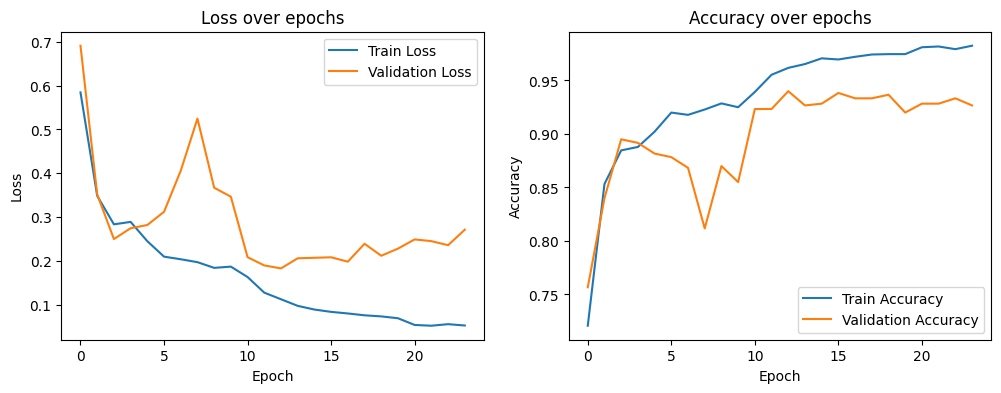

In [43]:
plot(train_losses_resnet, train_accuracies_resnet, val_losses_resnet, val_accuracies_resnet)

The plot of ResNet18 are as follows:

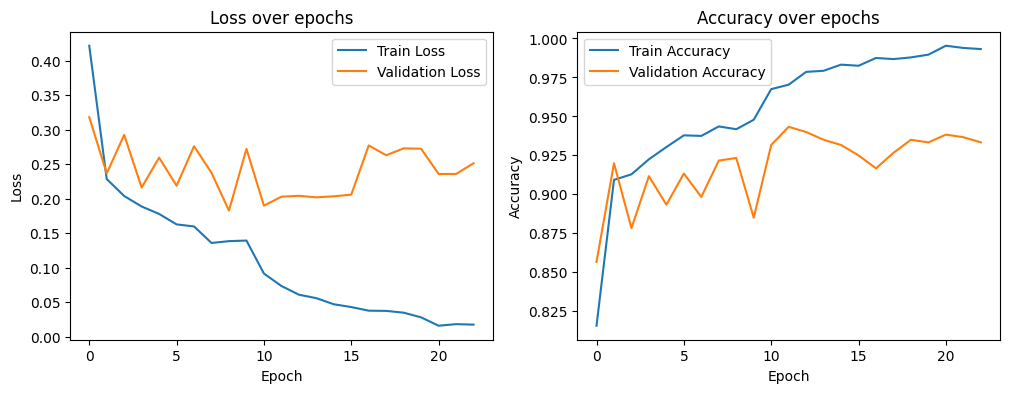

In [44]:
plot(train_losses_resnet18, train_accuracies_resnet18, val_losses_resnet18, val_accuracies_resnet18)

The plot of CNN are as follows:

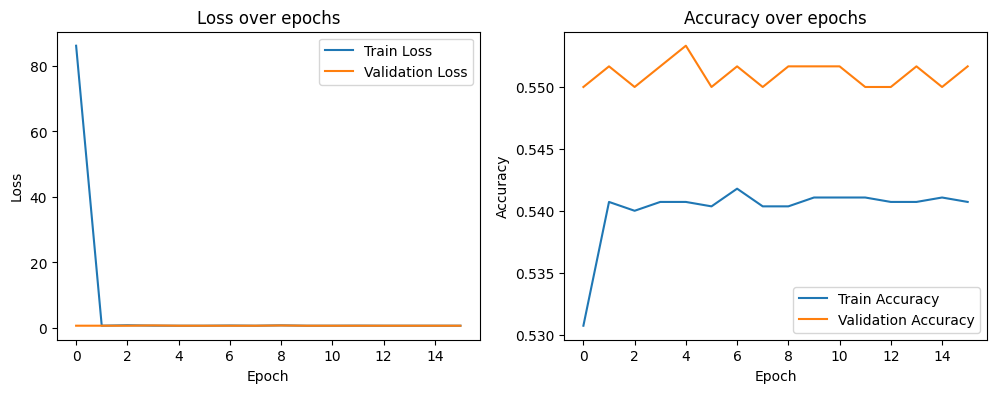

In [11]:
plot(train_loss_cnn, train_acc_cnn, val_loss_cnn, val_acc_cnn)

The plots of CNN are invalid, indicating several reasons:
1. Different hyperparemeters should be set, such as batch_size, learning rate and so on.

2. Simple networks may be hard to deal with such a question.

The plots of SVM are as follows:

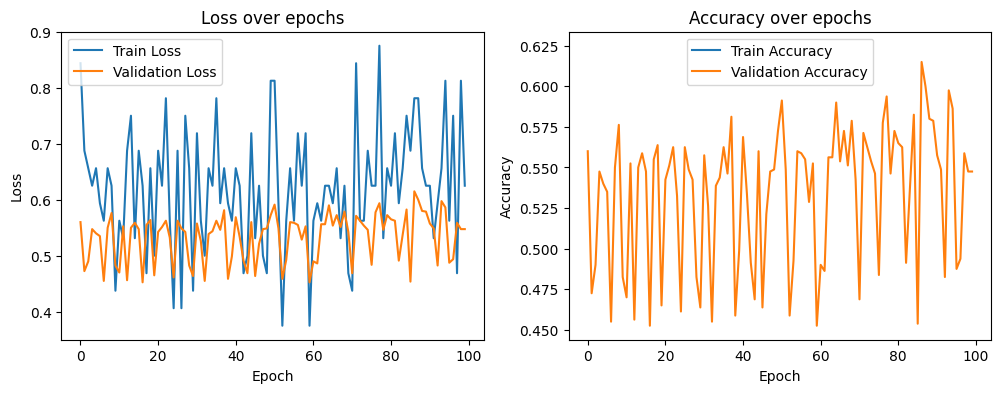

In [ ]:
plot(train_loss, train_acc, test_loss, batch_acc)

To be mentioned:

We treat the training of SVM which uses Mini-batch as an *epoch-like process*, where each mini-batch is an epoch4

train_loss and train_accuracy are based on each batch considering the memory limitation while validation_loss and validation_accuracy are based on the entire validation dataset.

The implementation of detection graph plot is as follows:

In [12]:
def plot_detection(train_losses, val_losses): 
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

The plot of ResNet50 are as follows:

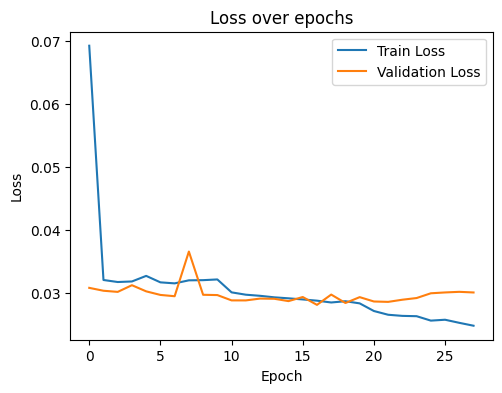

In [13]:
plot_detection(train_mse_losses_resnet, val_mse_losses_resnet)

The plot of ResNet18 are as follows:

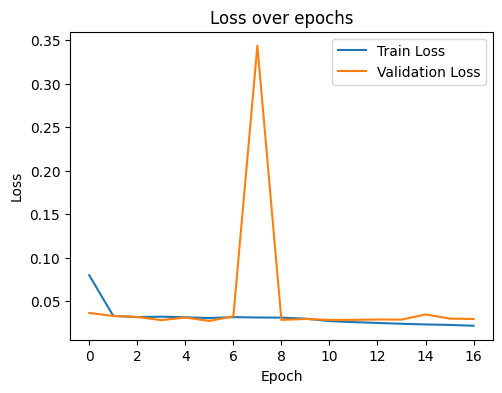

In [14]:
plot_detection(train_mse_losses_resnet18, val_mse_losses_resnet18)

The plot of CNN is as follows:

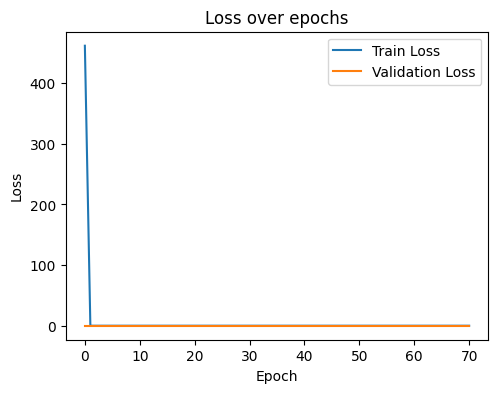

In [15]:
plot_detection(train_mse_cnn, val_mse_cnn)

# 9 Conclusions

**Contributions：**

1. Conduct Whether-Smile Classification and Head-Pos Detection on several models including SVM, CNN and ResNet.

2. Augument Data by rotating, flipping, dropping random pixels and so on to improve robustness.

3. Compare differences between different basic structures.

**Conclusions:**

1. Since geni4k is a high-quaility dataset, training or fine-tuning on this dataset will lead to a huge improvement of the model capability, with ResNet50 achieving an accuracy of 94%.

2. Comparing with training a model from scratch, fine-tuning a model which has been pretrained can improve the performance by a large margin. To be noticed, ResNet50 possesseds an accuracy of 94% and ResNet18 93%, compared with CNN 65%.

3. Increasing the depth of a model will improve the performance greatly. For instance, from 4-layer CNN to ResNet18 which is a stack of 18 CNNs combined with residual connection, the accuracy is increased from 55% to 93%. However, ResNet18 is comparable to ResNet50 in this task. I suppose that it is due to classification is a simple task, therefore, only increasing the depth will lead to convergence quickly. If higher accuracy needs to be achieved, some align methods should be used.

4. For machine learning model, e.g. svm, we can see that they may perform quite good at some certain batches while perform very bad at others. Since it scans through the whole dataset, its flexibility is influenced a lot.

**Improvements:**:

1. Firstly use ResNet model to do smile detection and pose detection.

2. Conduct a comprehensive survey on the effectiveness of different models on smile detection and pose detection, including machine learning algorithm and deep neural network.

**Future Work:**:

1. Since the smile detection is an old task, and nowadays LLMs have been prevelant, maybe we can use visual LLM for smile detection.

2. Since there are only 4000 pictures, we can use Multi-modal LLM to annotate, like blip, clip and so on.

3. To make the results more saliency, perhaps the label that indicates whether smiling or not is not enough, we need more fine-grained label like the human pos, the face pos and so on to predict. Therefore, we may firstly align the image to find humans and then feed the human image to the predict model, reducing noise.

# Notice

For more information, please refer to my github repo:

https://github.com/YuchenFan48/Project-ML